In [3]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from functools import reduce
import numpy.ma as ma
import scipy.interpolate
import numpy as np
import xarray as xr
import sys,time,os
import random, warnings
import seaborn as sns
from matplotlib import cm, colors

In [4]:
sys.path.append(os.path.abspath("/work/bb1018/b380873/tropic_vis/traj/"))
sys.path.append(os.path.abspath("/work/bb1018/b380873/tropic_vis/utilities/"))
from flighttrack import *
from plotting_utilities import *
from thermodynamic_functions import *
from icetraj import *
#from xhistogram.xarray import histogram as xhist
farbe = sim_colors()

# Comparison of StratoClim measurements and ICON synthetic flight tracks (vertical profiles)

### (1) Read in-situ data and group by altitude

In [ ]:
# Time range from Lee et al. 2019 (6:20-6:48 UTC)
time0 = datetime(2017, 8, 8, 6, 20)
timef = datetime(2017, 8, 8, 6, 48)
# Full flight track times
#time0 = datetime(2017, 8, 8, 4, 0)
#timef = datetime(2017, 8, 8, 7, 15)

# Read in-situ data
alt1, qv_flash, qv_fish, alt2, qi, alt3, temp, theta, alt4, rhice_flash, rhice_fish = \
    read_flighttrack( time0, timef )

# Bin the in-situ data altitudinally
min_alt = 14000  # 5000
max_alt = 22000
bins_sims, temp_SC_stats, theta_SC_stats, qv_flash_SC_stats, qv_fish_SC_stats, qi_SC_stats, RHi_SC_stats = \
    bin_flighttrack( min_alt, max_alt, alt1, qv_flash, qv_fish, alt2, qi, alt3, temp, theta, alt4, rhice_flash, \
                    rhice_fish )

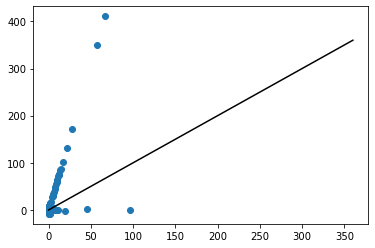

In [5]:
# Does FISH total water - FLASH gas-phase water equal the IWC? Does not seem so...
iwc_maybe = qv_fish - qv_flash

fig = plt.figure()
plt.scatter(qi, iwc_maybe)
plt.plot(np.arange(0,400,40), np.arange(0,400,40),'k')

### (2a) Single-variable functions to calculate synthetic flight track statistics in altitude bins
#### In general, multivariate versions of these functions are run from the traj/syntraj/ directory

In [6]:
# Calculate the mean, median, and standard deviation of <var> in a given set of simulation trajs
# This function does not fix the number of elements per bin.
# var_names = ['temp', 'air_pressure', 'qv', 'qc', 'qi', 'qs', 'qg', 'clc', 'omega', 'alt', 'lon', 'lat']

def syntraj_stats( alt_ICON, fi_ICON, indx, bins_sim, var ):
    
    # Store 3 statistics over <n> bins for 625 trajectories
    n = bins_sim.shape[0]
    stats = np.empty((3, n, alt_ICON.shape[1]))
    stats[:] = np.nan
    
    for i in np.arange(alt_ICON.shape[1]):
        print(i)
        var_list = [ [] for k in np.arange(n) ]
        
        # Group <var> values along this trajectory into bins
        for elem_idx, group_idx in enumerate( indx[:, i] ):
            var_list[int(group_idx-1)].append( fi_ICON[var][elem_idx, i].item() )
        
        # Calculate statistics in each bin
        for k in np.arange(n):
            stats[0, k, i] = np.nanmean( var_list[k] )
            stats[1, k, i] = np.nanmedian( var_list[k] )
            stats[2, k, i] = np.nanstd( var_list[k] )
                
    return stats

In [7]:
# Calculate the mean, median, and standard deviation of <var> in a given set of simulation trajs
# This function fixes the number of elements per bin.
# var_names = ['temp', 'air_pressure', 'qv', 'qc', 'qi', 'qs', 'qg', 'clc', 'omega', 'alt', 'lon', 'lat']

def syntraj_stats_fixed( alt_ICON, fi_ICON, indx, bins_sim, var ):
    
    # Store 3 statistics over <n> bins for 625 trajectories
    n = bins_sim.shape[0]
    stats = np.empty((3, n, alt_ICON.shape[1]))
    stats[:] = np.nan
    
    # Read in the number of in-situ measurements in each bin
    basedir = '/work/bb1018/b380873/tropic_vis/'
    Stratoclim_temp_len = np.load(basedir + 'output/Stratoclim_temp_len.npy')
    Stratoclim_qv_len = np.load(basedir + 'output/Stratoclim_qv_len.npy')
    
    for i in np.arange(5):#alt_ICON.shape[1]):
        #if i%50 == 0:
        print(i)
        var_list = [ [] for i in np.arange(n) ]

        # Group <var> values along this trajectory into bins.
        for elem_idx, group_idx in enumerate( indx[:,i] ):
            var_list[int(group_idx-1)].append( fi_ICON[var][elem_idx, i].item() )
    
        # Only retain the corresponding number of elements from the measurements
        # We do this calculation only for n-1 bins as the last bin contains the whole "upper-level" trajectory set (z ~ 22 km)
        var_list_fixed = [ [] for i in np.arange(n) ]
        for j in np.arange(n-1):
            if var_list[j]:
                var_list_fixed[j] = random.sample( var_list[j], Stratoclim_temp_len[j] )  
                # To be revisited above, whether Stratoclim_temp_len[j] is relevant for all variables
        
            if var_list_fixed[j]:
                stats[0, j, i] = np.nanmean( var_list_fixed[j] )
                stats[1, j, i] = np.nanmedian( var_list_fixed[j] )
                stats[2, j, i] = np.nanstd( var_list_fixed[j] )
            
    return stats

### (2b) Read in pre-calculated statistics for the synthetic flight tracks

In [3]:
# Which set of trajectory statistics do you want to open?

tag = ''  # Default 625 synthetic trajectories
#tag = '_fixed' # Fix the number of elements per bin to that of the in-situ measurements
#tag = '_2' # Second set of 625 synthetic trajectories to test reproducibility
#tag = '_collocate' # Minimize the Euclidean distance between sim and obs values
#tag = '_pinpoint' # Find the closest numerical value to the obs within the sim
#tag = '_full'

stats1 = np.load('output/ICON_syntrajs_0V1M0A0R_stats' + tag + '.npy')  #'ICON_syntrajs_0V1M0A0R_stats_70bins.npy'
stats2 = np.load('output/ICON_syntrajs_0V2M0A0R_stats' + tag + '.npy')  #'ICON_syntrajs_0V2M0A0R_stats_70bins.npy'
stats3 = np.load('output/ICON_syntrajs_0V2M1A1R_stats' + tag + '.npy')  #'ICON_syntrajs_0V2M1A1R_stats_70bins.npy'

warnings.filterwarnings(action='once')
sim_stats = np.stack((stats1, stats2, stats3))
sim_list = ['0V1M0A0R', '0V2M0A0R', '0V2M1A1R']

### (3) Does including the snow mass mixing ratio affect the qi profile measurement-model comparison? (No)

In [4]:
# Full Flight 7 statistics
if tag == '_full':
    time0 = datetime(2017, 8, 8, 4, 0)
    timef = datetime(2017, 8, 8, 7, 15)
    min_alt = 5000
    max_alt = 22000
    icon_sz = 50
    y1 = 5
    
# Time range from Lee et al. 2019 (6:20-6:48 UTC)    
else:
    time0 = datetime(2017, 8, 8, 6, 20)
    timef = datetime(2017, 8, 8, 6, 48)
    min_alt = 14000  
    max_alt = 22000
    icon_sz = 100
    y1 = 14.8

# Read in-situ data
alt1, qv_flash, qv_fish, alt2, qi, alt3, temp, theta, alt4, rhice_flash, rhice_fish = \
    read_flighttrack( time0, timef )

# Bin the in-situ data altitudinally
bins_sims, temp_SC_stats, theta_SC_stats, qv_flash_SC_stats, qv_fish_SC_stats, qi_SC_stats, RHi_SC_stats = \
    bin_flighttrack( min_alt, max_alt, alt1, qv_flash, qv_fish, alt2, qi, alt3, temp, theta, alt4, rhice_flash, \
                    rhice_fish )

/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/pf/b/b380873/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:994: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


Text(0.03, 0.93, '(d)')

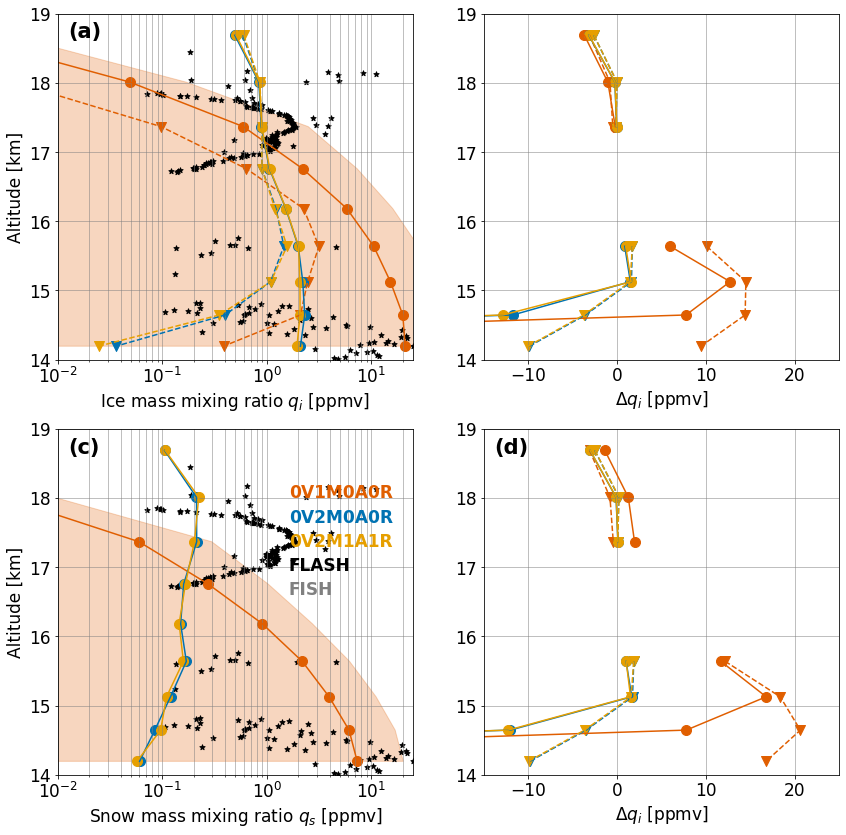

In [5]:
fs = 17
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
y2 = 19
icon_lw = 1.5
icon_alfa = 1
k = 0 # If k = 0, compare means. If k = 1, compare medians.

y1 = 14
ax[0,0].set_xlim([0.01, 25])
ax[1,0].set_xlim([0.01, 25])
ax[0,1].set_xlim([-15, 25])
ax[1,1].set_xlim([-15, 25])

qim = np.nanmean(sim_stats[0,3,k],axis=1)
ax[0,0].fill_betweenx( y=bins_sims/1000, x1=qim - np.nanmean(sim_stats[0,3,2],axis=1), x2=qim + np.nanmean(sim_stats[0,3,2],axis=1), alpha=0.25, color=farbe['0V1M0A0R'] )
ax[0,0].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
ax[0,0].scatter(qi, alt2/1000, color='k', s=30, marker='*')

# We don't use k below because we are showing both the mean and median always.
for s_indx, s_name in enumerate( sim_list ):
    ax[0,0].scatter(np.nanmean(sim_stats[s_indx,3,0],axis=1), bins_sims/1000, color=farbe[s_name], s=icon_sz)
    ax[0,0].plot(np.nanmean(sim_stats[s_indx,3,0],axis=1), bins_sims/1000, color=farbe[s_name], lw=icon_lw)
    ax[0,0].scatter(np.nanmedian(sim_stats[s_indx,3,1],axis=1), bins_sims/1000, marker='v', color=farbe[s_name], s=icon_sz)
    ax[0,0].plot(np.nanmedian(sim_stats[s_indx,3,1],axis=1), bins_sims/1000, ls='--', color=farbe[s_name], lw=icon_lw)
ax[0,0].set_ylim([y1, y2])
ax[0,0].set_xscale('log')
#ax[0,0].set_xlim([10**(-3),10**2])
ax[0,0].set_xlabel(r'Ice mass mixing ratio $q_i$ [ppmv]', fontsize=fs)
ax[0,0].tick_params('both',labelsize=fs)
ax[0,0].text(0.03, 0.93, '(a)', weight='bold', fontsize=fs+4, transform=ax[0,0].transAxes)
ax[0,0].set_ylabel('Altitude [km]', fontsize=fs)

ax[0,1].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
for s_indx, s_name in enumerate( sim_list ):
    ax[0,1].scatter(np.nanmean(sim_stats[s_indx,3,k,:,:20],axis=1) - qi_SC_stats[0], bins_sims/1000, color=farbe[s_name], s=icon_sz)
    ax[0,1].plot(np.nanmean(sim_stats[s_indx,3,k,:,:20],axis=1) - qi_SC_stats[0], bins_sims/1000, color=farbe[s_name], lw=icon_lw)
    ax[0,1].scatter(np.nanmedian(sim_stats[s_indx,3,0],axis=1) - qi_SC_stats[1], bins_sims/1000, marker='v', color=farbe[s_name], s=icon_sz)
    ax[0,1].plot(np.nanmedian(sim_stats[s_indx,3,0],axis=1) - qi_SC_stats[1], bins_sims/1000, ls='--', color=farbe[s_name], lw=icon_lw)
ax[0,1].set_ylim([y1, y2])
#ax[0,1].set_xscale('log')
ax[0,1].set_xlabel(r'$\Delta q_i$ [ppmv]', fontsize=fs)
ax[0,1].tick_params('both',labelsize=fs)
ax[0,1].text(0.03, 0.93, '(b)', weight='bold', fontsize=fs+4, transform=ax[1,1].transAxes)

ax[1,0].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
qsm = np.nanmean( sim_stats[0,4,k], axis=1 )
ax[1,0].fill_betweenx( y=bins_sims/1000, x1=qsm - np.nanmean(sim_stats[0,4,2],axis=1), x2=qsm + np.nanmean(sim_stats[0,4,2],axis=1), alpha=0.25, color=farbe['0V1M0A0R'] )
ax[1,0].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
ax[1,0].scatter(qi, alt2/1000, color='k', s=30, marker='*')
for s_indx, s_name in enumerate( sim_list ):
    ax[1,0].scatter(np.nanmean( sim_stats[s_indx,4,k], axis=1 ), bins_sims/1000, color=farbe[s_name], s=icon_sz)
    ax[1,0].plot(np.nanmean( sim_stats[s_indx,4,k], axis=1 ), bins_sims/1000, color=farbe[s_name], lw=icon_lw)
ax[1,0].text(0.65, 0.8, '0V1M0A0R', fontsize=fs, weight='bold', color=farbe['0V1M0A0R'], transform=ax[1,0].transAxes)
ax[1,0].text(0.65, 0.73, '0V2M0A0R', fontsize=fs, weight='bold', color=farbe['0V2M0A0R'], transform=ax[1,0].transAxes)
ax[1,0].text(0.65, 0.66, '0V2M1A1R', fontsize=fs, weight='bold', color=farbe['0V2M1A1R'], transform=ax[1,0].transAxes)
ax[1,0].text(0.65, 0.59, 'FLASH', fontsize=fs, weight='bold', transform=ax[1,0].transAxes)
ax[1,0].text(0.65, 0.52, 'FISH', fontsize=fs, weight='bold', color='gray', transform=ax[1,0].transAxes)
ax[1,0].set_ylim([y1, y2])
ax[1,0].set_xscale('log')
ax[1,0].set_xlabel(r'Snow mass mixing ratio $q_s$ [ppmv]', fontsize=fs)
ax[1,0].set_ylabel('Altitude [km]', fontsize=fs)
ax[1,0].tick_params('both',labelsize=fs)
ax[1,0].text(0.03, 0.93, '(c)', weight='bold', fontsize=fs+4, transform=ax[1,0].transAxes)

ax[1,1].grid(b=True, which='both', axis='both', color='gray', linewidth=0.5)
for s_indx, s_name in enumerate( sim_list ):
    ax[1,1].scatter(np.nanmean(sim_stats[s_indx,3,k],axis=1) + np.nanmean(sim_stats[s_indx,4,k]) - qi_SC_stats[0], bins_sims/1000, color=farbe[s_name], s=icon_sz)
    ax[1,1].plot(np.nanmean(sim_stats[s_indx,3,k],axis=1) + np.nanmean(sim_stats[s_indx,4,k]) - qi_SC_stats[0], bins_sims/1000, color=farbe[s_name], lw=icon_lw)
    ax[1,1].scatter(np.nanmedian(sim_stats[s_indx,3,0],axis=1) + np.nanmedian(sim_stats[s_indx,4,0],axis=1) - qi_SC_stats[1], bins_sims/1000, marker='v', color=farbe[s_name], s=icon_sz)
    ax[1,1].plot(np.nanmedian(sim_stats[s_indx,3,0],axis=1) + np.nanmedian(sim_stats[s_indx,4,0],axis=1) - qi_SC_stats[1], bins_sims/1000, ls='--', color=farbe[s_name], lw=icon_lw)
ax[1,1].set_ylim([y1, y2])
#ax[1,1].set_xscale('log')
ax[1,1].set_xlabel(r'$\Delta q_i$ [ppmv]', fontsize=fs)
ax[1,1].tick_params('both',labelsize=fs)
ax[1,1].text(0.03, 0.93, '(d)', weight='bold', fontsize=fs+4, transform=ax[1,1].transAxes)

#fig.savefig('output/qi-qs-comp' + tag + '.pdf')

### (4a) Plot vertical profiles of qi in temperature coordinates for both in-situ measurements and ICON synthetic flight tracks

In [ ]:
# All sets of trajectory statistics
stats_1M0A0R = np.nanmean( np.load( 'output/ICON_syntrajs_0V1M0A0R_stats.npy' ), axis=3)
stats_2M0A0R = np.nanmean( np.load( 'output/ICON_syntrajs_0V2M0A0R_stats.npy' ), axis=3)
stats_2M1A1R = np.nanmean( np.load( 'output/ICON_syntrajs_0V2M1A1R_stats.npy' ), axis=3)

stats_1M0A0R = np.reshape( stats_1M0A0R, (1, 4, 3, 13) )
stats_2M0A0R = np.reshape( stats_2M0A0R, (1, 4, 3, 13) )
stats_2M1A1R = np.reshape( stats_2M1A1R, (1, 4, 3, 13) )

tag_list = ['_2', '_collocate', '_pinpoint']
for t in tag_list:
    new = np.load('output/ICON_syntrajs_0V1M0A0R_stats' + t + '.npy')
    new = np.reshape( np.nanmean( new, axis=3 ), (1, 4, 3, 13) )
    stats_1M0A0R = np.concatenate( (stats_1M0A0R, new), axis=0 )
    
    new = np.load('output/ICON_syntrajs_0V2M0A0R_stats' + t + '.npy')
    new = np.reshape( np.nanmean( new, axis=3 ), (1, 4, 3, 13) )
    stats_2M0A0R = np.concatenate( (stats_2M0A0R, new), axis=0 )
    
    new = np.load('output/ICON_syntrajs_0V2M1A1R_stats' + t + '.npy')
    new = np.reshape( np.nanmean( new, axis=3 ), (1, 4, 3, 13) )
    stats_2M1A1R = np.concatenate( (stats_2M1A1R, new), axis=0 )

### (4b) Plot vertical profiles of qi in supersaturation coordinates for both in-situ measurements and ICON synthetic flight tracks

# Variability in ICON synthetic trajectories

### (1) Updraft velocities

In [5]:
basedir = '/work/bb1018/b380873/model_output/ICON/'
syn_traj = xr.open_dataset(basedir + 'ICON_synthetic_trajs_0V1M0A0R.nc')
w = syn_traj['omega'].isel(time=slice(0,10800))
t = syn_traj['time'].isel(time=slice(0,10800)).values

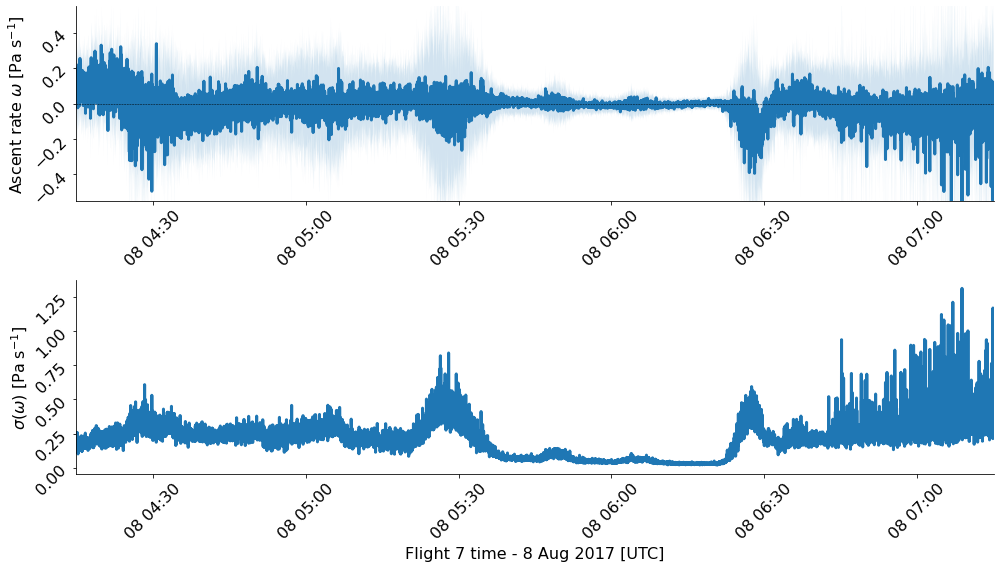

In [4]:
fs = 16
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14,8))
wm = w.mean(dim='ntraj')
wstd = w.std(dim='ntraj')
ax[0].plot(t, wm, linewidth=3)
ax[0].plot([t.min(), t.max()], [0, 0], color='k', linestyle='--', linewidth=0.5)
ax[0].plot()
ax[0].fill_between(t, wm - wstd, wm + wstd, alpha=0.2)
ax[0].set_xlim([t.min(), t.max()])
ax[0].set_ylim([-0.55, 0.55])
ax[0].set_ylabel(r'Ascent rate $\omega$ [Pa s$^{-1}$]', fontsize=fs)
sexy_axes(ax[0], fs=16)

ax[1].plot(t, wstd, linewidth=3)
ax[1].set_xlim([t.min(), t.max()])
ax[1].set_xlabel('Flight 7 time - 8 Aug 2017 [UTC]', fontsize=fs)
ax[1].set_ylabel(r'$\sigma(\omega)$ [Pa s$^{-1}$]', fontsize=fs)
sexy_axes(ax[1], fs)
plt.tight_layout()
#fig.savefig('output/syntraj_wcheck_full.pdf',bbox_inches='tight')
plt.show()

### (2) Temperatures

In [6]:
T = syn_traj['temp'].isel(time=slice(0,10800))
t = syn_traj['time'].isel(time=slice(0,10800)).values

# Read in-situ data
daten = xr.open_dataset('obs/stratoclim2017.geophysika.0808_1.filtered_per_sec.nc')
j = 1942
T_Stratoclim = daten['BEST:TEMP'][j:j+10801]
t_Stratoclim = daten['time'][j:j+10801]

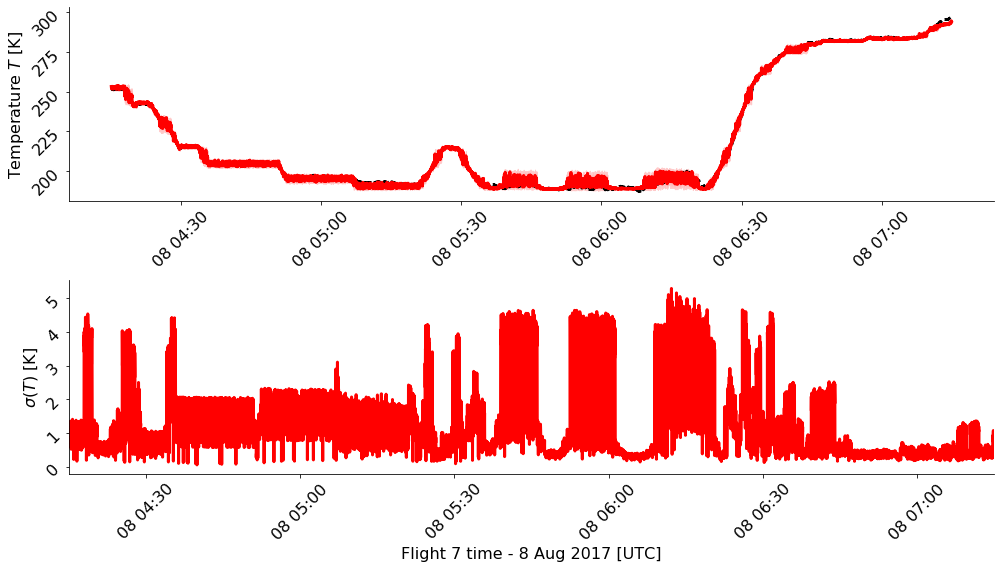

In [7]:
fs = 16
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14,8))
Tm = T.mean(dim='ntraj')
Tstd = T.std(dim='ntraj')
ax[0].plot(t_Stratoclim, T_Stratoclim, color='k', linewidth=2.5, linestyle='--')
ax[0].plot(t, Tm, color='red', linewidth=3)
ax[0].fill_between(t, Tm - Tstd, Tm + Tstd, color='red', alpha=0.2)
#ax[0].set_xlim([t.min(), t.max()])
ax[0].set_ylabel(r'Temperature $T$ [K]', fontsize=fs)
sexy_axes(ax[0], fs=16)

ax[1].plot(t, Tstd, color='red', linewidth=3)
ax[1].set_xlim([t.min(), t.max()])
ax[1].set_xlabel('Flight 7 time - 8 Aug 2017 [UTC]', fontsize=fs)
ax[1].set_ylabel(r'$\sigma(T)$ [K]', fontsize=fs)
sexy_axes(ax[1], fs)
plt.tight_layout()

#fig.savefig('output/syntraj_Tcheck_full.pdf',bbox_inches='tight')
plt.show()

### (3) Ice mass mixing ratios

In [8]:
qi = syn_traj['qi'].isel(time=slice(0,10800))
t = syn_traj['time'].isel(time=slice(0,10800)).values

# Multiply qv_s by 10^6 to translate kg kg-1 to ppmv.
mw_dryair = 28.97*1000    # kg air (mol air)-1
mw_watvap = 18.02*1000    # kg wv (mol wv)-1
conv = mw_dryair / mw_watvap
qim_ppmv = qi.mean(dim='ntraj') * conv * 10**6
qistd_ppmv = qi.std(dim='ntraj') * conv * 10**6

# Read in-situ data
daten = xr.open_dataset('obs/stratoclim2017.geophysika.0808_1.filtered_per_sec.nc')
j = 1942
qi_Stratoclim = daten['BEST:IWC'][j:j+10801]
t_Stratoclim = daten['time'][j:j+10801]

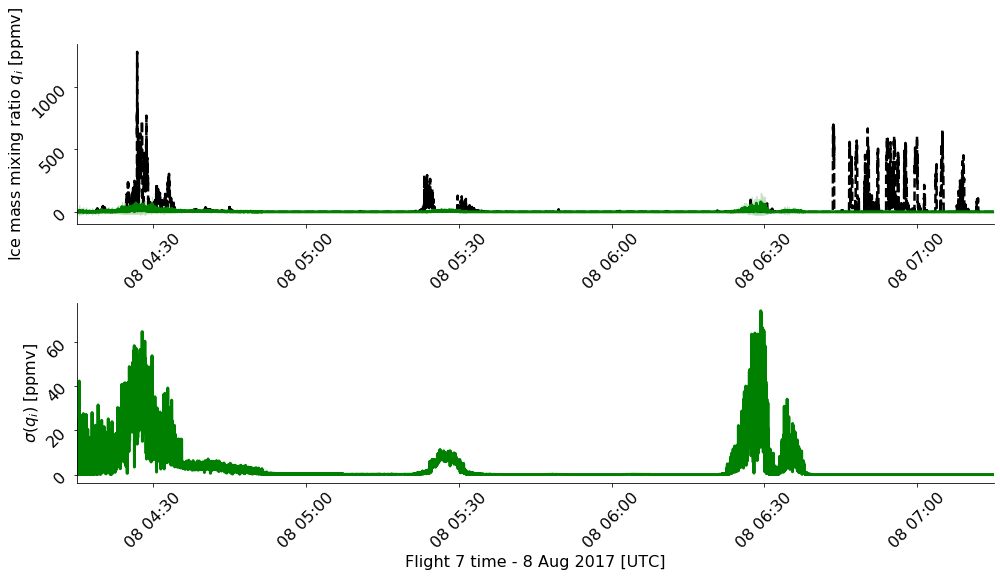

In [9]:
fs = 16
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14,8))
ax[0].plot(t_Stratoclim, qi_Stratoclim, color='k', linewidth=2.5, linestyle='--')
ax[0].plot(t, qim_ppmv, color='green', linewidth=3)
ax[0].fill_between(t, qim_ppmv - qistd_ppmv, qim_ppmv + qistd_ppmv, color='green', alpha=0.2)
ax[0].set_xlim([t.min(), t.max()])
ax[0].set_ylabel(r'Ice mass mixing ratio $q_i$ [ppmv]', fontsize=fs)
sexy_axes(ax[0], fs=16)

ax[1].plot(t, qistd_ppmv, color='green', linewidth=3)
ax[1].set_xlim([t.min(), t.max()])
ax[1].set_xlabel('Flight 7 time - 8 Aug 2017 [UTC]', fontsize=fs)
ax[1].set_ylabel(r'$\sigma(q_i)$ [ppmv]', fontsize=fs)
sexy_axes(ax[1], fs)
plt.tight_layout()

#fig.savefig('output/syntraj_qicheck_full.pdf',bbox_inches='tight')
plt.show()

### (4) Vapor mass mixing ratios

In [10]:
qv = syn_traj['qv'].isel(time=slice(0,10800))
t = syn_traj['time'].isel(time=slice(0,10800)).values

# Multiply qv_s by 10^6 to translate kg kg-1 to ppmv.
mw_dryair = 28.97*1000    # kg air (mol air)-1
mw_watvap = 18.02*1000    # kg wv (mol wv)-1
conv = mw_dryair / mw_watvap
qvm_ppmv = qv.mean(dim='ntraj') #* conv * 10**6
qvstd_ppmv = qv.std(dim='ntraj') #* conv * 10**6

# Read in-situ data
daten = xr.open_dataset('obs/stratoclim2017.geophysika.0808_1.filtered_per_sec.nc')
j = 1942
qv_Stratoclim = daten['BEST:H2O_enh'][j:j+10801]
t_Stratoclim = daten['time'][j:j+10801]

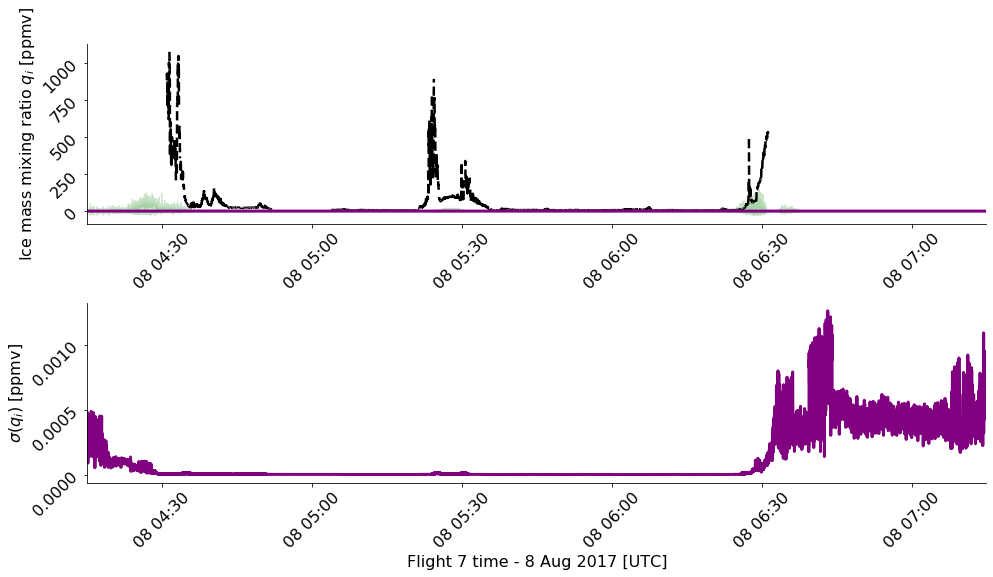

In [11]:
fs = 16
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14,8))
ax[0].plot(t_Stratoclim, qv_Stratoclim, color='k', linewidth=2.5, linestyle='--')
ax[0].plot(t, qvm_ppmv, color='purple', linewidth=3)
ax[0].fill_between(t, qim_ppmv - qistd_ppmv, qim_ppmv + qistd_ppmv, color='green', alpha=0.2)
ax[0].set_xlim([t.min(), t.max()])
ax[0].set_ylabel(r'Ice mass mixing ratio $q_i$ [ppmv]', fontsize=fs)
sexy_axes(ax[0], fs=16)

ax[1].plot(t, qvstd_ppmv, color='purple', linewidth=3)
ax[1].set_xlim([t.min(), t.max()])
ax[1].set_xlabel('Flight 7 time - 8 Aug 2017 [UTC]', fontsize=fs)
ax[1].set_ylabel(r'$\sigma(q_i)$ [ppmv]', fontsize=fs)
sexy_axes(ax[1], fs)
plt.tight_layout()

#fig.savefig('output/syntraj_qicheck_full.pdf',bbox_inches='tight')
plt.show()